## Feature selection

Hybrid method: Recursive feature elimination
This method consists of the following steps:

Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance or  coefficients derived from linear models.

Remove one feature -the least important- and build a machine learning algorithm utilising the remaining features.

Calculate a performance metric of choice: roc-auc, mse, rmse, accuracy, etc.

If the metric decreases by more than an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

Repeat steps 2-4 until all features have been evaluated.

I call this a hybrid method because:

it derives the importance derived from the machine learning algorithm, like embedded methods

it builds several machine learning models, like wrapper methods.

This method is faster than wrapper methods and often better than embedded methods. In practice, it works extremely well. 

One thing to note is that the minimum drop in performance to decide if a feature should be kept is set arbitrarily. The smaller the drop, the more features will be selected, and vice versa.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, RecursiveFeatureElimination

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

In [2]:
# Import dataset
load_dotenv()
# Load X and y splits
x_train_path = os.getenv("X_TRAIN_MERGED_SCALED")
x_test_path  = os.getenv("X_TEST_MERGED_SCALED")
y_train_path = os.getenv("Y_TRAIN_MERGED_SCALED")
y_test_path  = os.getenv("Y_TEST_MERGED_SCALED")

X_train = pd.read_csv(x_train_path)
X_test  = pd.read_csv(x_test_path)
y_train = pd.read_csv(y_train_path)
y_test  = pd.read_csv(y_test_path)

# Optional: quick check
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(875, 23) (875, 1)
(376, 23) (376, 1)


In [3]:
X_train

,RID,Gender,Ageatscreening,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,HipsSumVariancebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,30724,1,68.766600,30.0,0.439372,0.449830,-0.310769,-0.057975,-0.347856,-0.448372,...,-0.616233,-1.553987,-3.014887,1.341362,-2.506142,-0.072538,1.729962,-0.257601,0.188973,0.441671
1,973,0,76.923300,28.0,-0.897787,-0.704627,-0.417065,-0.823577,0.808385,-0.763564,...,-0.676678,0.088476,-1.245864,0.277013,-0.829339,0.125996,1.215330,-0.697663,1.243319,0.869884
2,30048,0,60.120464,29.0,0.844165,-0.659601,0.532557,-1.266330,-0.851072,-0.733375,...,-1.120482,0.738036,-0.860691,-0.900840,-0.218100,-0.526256,-0.676533,0.500947,0.711024,0.206708
3,30950,1,65.242980,29.0,0.448514,-0.783976,0.730526,0.568220,0.201516,1.262269,...,-0.495325,0.672895,0.570455,-0.162415,0.796400,0.669228,-0.443779,0.994111,0.359644,2.079358
4,31104,1,53.174538,29.0,-1.186722,-0.320633,0.887091,2.114615,1.317801,2.453484,...,-0.921515,0.985687,0.093213,0.076339,0.572736,1.275942,-0.269289,1.446447,-0.046236,0.114960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,1168,1,81.282200,29.0,-0.248488,-0.027023,0.888073,0.662068,0.265437,0.765040,...,1.300998,-0.750174,1.595055,0.454051,0.916475,0.608826,-0.359318,1.109268,-0.068742,0.991036
871,1121,1,56.254800,24.0,-1.148761,0.308420,NaN,-1.567693,1.444640,-1.838439,...,-0.453973,0.220467,-0.466099,0.916348,-0.153850,1.358527,1.261897,1.109268,-0.280158,0.429740
872,30404,1,63.534565,26.0,0.004421,0.138551,-0.058230,-0.599736,-0.017667,-0.736988,...,-0.245620,0.316113,0.020680,-0.807918,0.148746,-0.202100,-0.735200,-0.247931,-0.548208,-0.778206
873,30995,1,58.491444,30.0,-1.103475,0.521710,0.147755,1.949610,1.617563,1.555780,...,-0.769378,0.698120,-0.234244,0.313983,0.185186,1.443140,0.059937,0.914603,1.012206,1.337187


In [4]:
imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_missForest = imputer_nonLin.transform(X_train)
X_test_missForest = imputer_nonLin.transform(X_test)

In [5]:
X_train_knn_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
constant_step = pipe.named_steps['constant']
quasi_constant_step = pipe.named_steps['quasi-constant']
duplicated_step = pipe.named_steps['duplicated']

print("Constant features removed:", constant_step.features_to_drop_)
print("Quasi-constant features removed:", quasi_constant_step.features_to_drop_)
print("Duplicate features removed:", duplicated_step.features_to_drop_)

Constant features removed: []
Quasi-constant features removed: []
Duplicate features removed: set()


In [8]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((875, 23), (376, 23))

In [9]:
model = GradientBoostingClassifier(random_state=42,)

# Define cross-validation strategy
scv = StratifiedKFold(n_splits=5, 
                      shuffle=True, 
                      random_state=42)

# Setup the RFE selector
sel = RecursiveFeatureElimination(
    estimator=model,
    scoring="roc_auc_ovr_weighted",
    threshold=0.0005,
    cv=scv
)

# this may take quite a while, because
# we are building a lot of models with cross-validation
sel.fit(X_train_t, y_train)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: D

RecursiveFeatureElimination(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                            estimator=GradientBoostingClassifier(random_state=42),
                            scoring='roc_auc_ovr_weighted', threshold=0.0005)

In [10]:
# performance of model trained using all features

sel.initial_model_performance_

np.float64(0.9061957119730939)

In [11]:
# drop in performance caused by shuffling the feature

sel.performance_drifts_

{'Gender': np.float64(0.0010835566600002622),
 'HipsVariancebaseline': np.float64(0.0003692102693642063),
 'HipsSumAveragebaseline': np.float64(0.0018552851122786151),
 'HipsClusterShadebaseline': np.float64(0.00045068512072787836),
 'HipsSumVariancebaseline': np.float64(0.0007065215963676374),
 'ERCsSumAveragebaseline': np.float64(-0.0025305138250484305),
 'ERCsClusterShadebaseline': np.float64(0.0006459175715344267),
 'ERCsVariancebaseline': np.float64(0.005765029285747403),
 'HipsCorelationbaseline': np.float64(0.0035578536555905815),
 'ERCsASMbaseline': np.float64(0.0015585127181717562),
 'HipsASMbaseline': np.float64(0.0030878216204986986),
 'ERCsEntropybaseline': np.float64(0.003884387034274739),
 'HipsContrastbaseline': np.float64(0.0017158968219428417),
 'ERCsCorelationbaseline': np.float64(-0.0006942515535203198),
 'ERCsSumVariancebaseline': np.float64(0.0017615149342424807),
 'Ageatscreening': np.float64(0.002454870264957165),
 'ERCsVolumebaseline': np.float64(0.0009020393100

In [12]:
sel.feature_importances_

Gender                        0.001330
HipsVariancebaseline          0.007240
HipsSumAveragebaseline        0.007385
HipsClusterShadebaseline      0.008187
HipsSumVariancebaseline       0.009006
ERCsSumAveragebaseline        0.010353
ERCsClusterShadebaseline      0.011745
ERCsVariancebaseline          0.011996
HipsCorelationbaseline        0.012530
ERCsASMbaseline               0.015295
HipsASMbaseline               0.016028
ERCsEntropybaseline           0.016359
HipsContrastbaseline          0.018233
ERCsCorelationbaseline        0.022337
ERCsSumVariancebaseline       0.023838
Ageatscreening                0.024340
ERCsVolumebaseline            0.025345
ERCsContrastbaseline          0.028050
HipsEntropybaseline           0.030914
ERCs_thicknessbaseline        0.039530
HipposcampusVolumebaseline    0.067219
RID                           0.111418
MMSE0m                        0.481321
dtype: float64

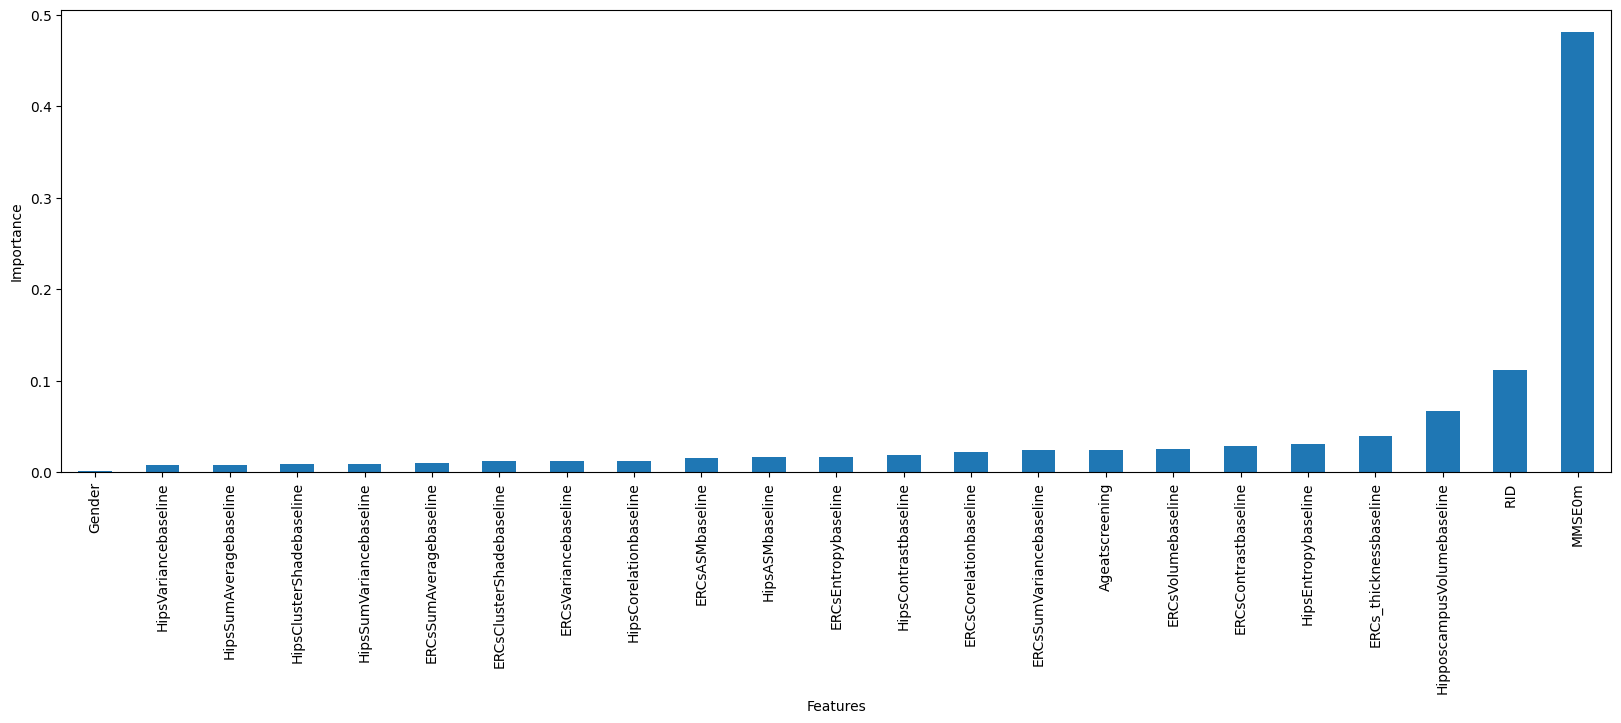

In [13]:
# importance of all features based of initial model
sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

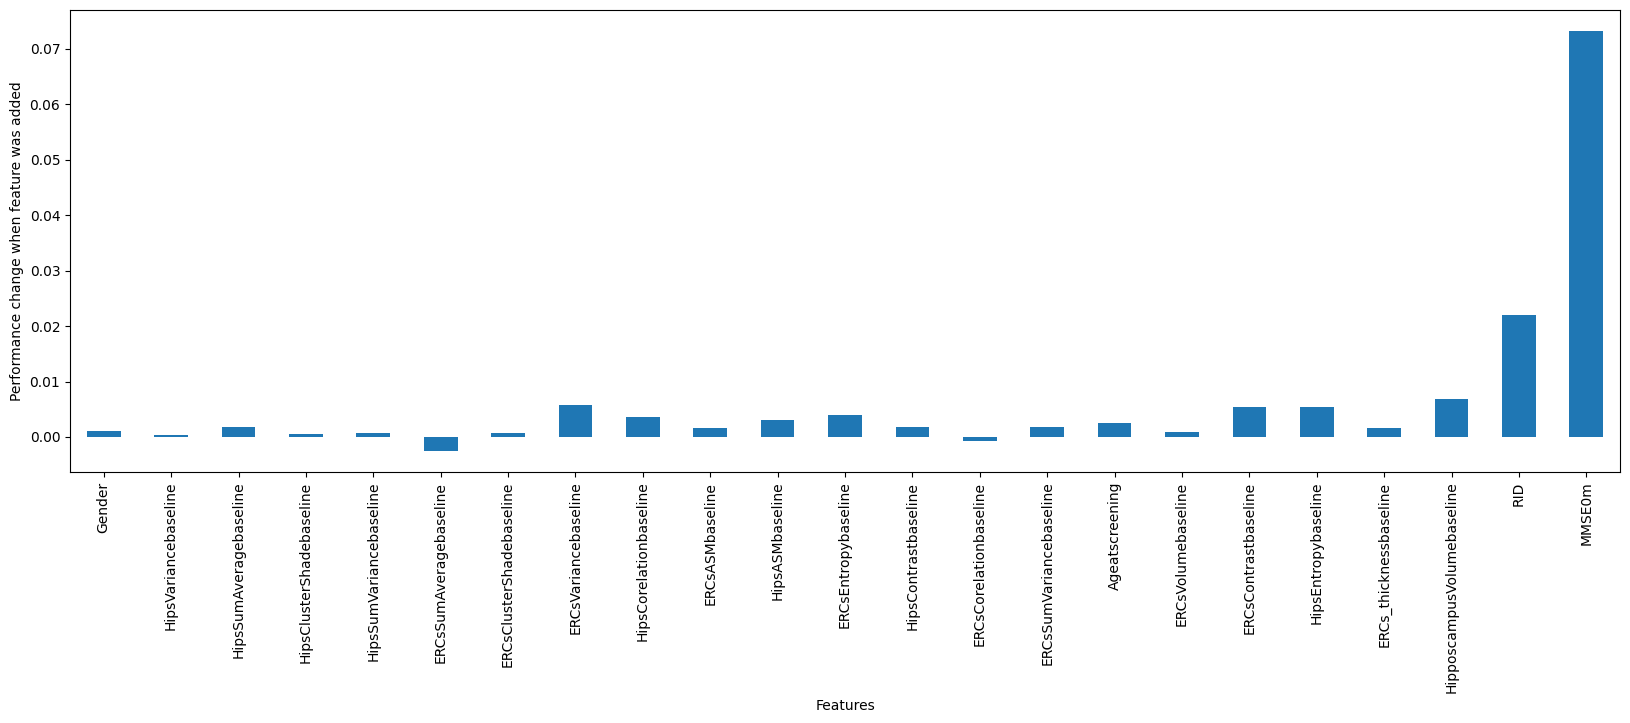

In [14]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [15]:
# Number of features that will be removed

sel.features_to_drop_

['HipsVariancebaseline',
 'HipsClusterShadebaseline',
 'ERCsCorelationbaseline',
 'ERCsSumAveragebaseline']

In [16]:
# select features
X_train_t = sel.transform(X_train_knn_t)
X_test_t = sel.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((875, 19), (376, 19))

In [17]:
X_train_t.columns

Index(['RID', 'Gender', 'Ageatscreening', 'MMSE0m', 'HipsASMbaseline',
       'HipsContrastbaseline', 'HipsCorelationbaseline',
       'HipsSumAveragebaseline', 'HipsSumVariancebaseline',
       'HipsEntropybaseline', 'ERCsASMbaseline', 'ERCsContrastbaseline',
       'ERCsVariancebaseline', 'ERCsSumVariancebaseline',
       'ERCsEntropybaseline', 'ERCsClusterShadebaseline',
       'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline'],
      dtype='object')

## Classification Test

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def run_model(classifier_name, X_train, y_train):
        
        columns = len(X_train.columns)
        
        # Initialize the model based on classifier_name
        if classifier_name == "Random Forest":
                model = RandomForestClassifier(n_estimators=100, 
                                        max_depth=5, 
                                        random_state=42, 
                                        class_weight="balanced")
                
        elif classifier_name == "XGBoost":
        # XGBClassifier sometimes issues warnings about label encoding. 
        # We disable the use_label_encoder and set an evaluation metric.
                model = XGBClassifier(n_estimators=100, 
                                max_depth=5, 
                                random_state=42,
                                eval_metric="logloss")
        
        elif classifier_name == "NGBoost":
                model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                                      n_estimators=100,
                                      verbose=False)
                
        elif classifier_name == "Logistic Regression":
                model = LogisticRegression(
                class_weight="balanced",
                solver="lbfgs",
                max_iter=500,
                random_state=42
                )

        else:
                raise ValueError("Unknown classifier")
                
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": "ANOVA",
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": columns,
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [19]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", X_train_knn_t, y_train)
trained_rf_t, metrics_rf_t = run_model("Random Forest", X_train_t, y_train)

trained_xgb_n, metrics_xgb_n = run_model("XGBoost", X_train_knn_t, y_train)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", X_train_t, y_train)

trained_ngb_n, metrics_ngb_n = run_model("NGBoost", X_train_knn_t, y_train)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", X_train_t, y_train)

trained_lg_n, metrics_lg_n = run_model("Logistic Regression", X_train_knn_t, y_train)
trained_lg_t, metrics_lg_t = run_model("Logistic Regression", X_train_t, y_train)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarni

In [20]:
validation_df = pd.concat([metrics_rf_n, metrics_rf_t, metrics_xgb_n, metrics_xgb_t, metrics_ngb_n, metrics_ngb_t, metrics_lg_n, metrics_lg_t])
validation_df_report = validation_df.set_index(["Feature Selection", "Classifier", "Metric", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Feature Selection Classifier          Metric            Fit Time Total Features               
ANOVA             Random Forest       balanced_accuracy 0.796    23                   0.867   
                                                        0.504    19                   0.856   
                  XGBoost             balanced_accuracy 0.837    23                   1.000   
                                                        0.864    19                   1.000   
                  NGBoost             balanced_accuracy 2.558    23                   0.753   
                                                        2.203    19                   0.753   
                  Logistic Regression balanced_accuracy 0.272    23                   0.697   
                                                        0.263    19                   0.698   

                                                                                 Std Train  \
Feature Selection Classifier          Metric            Fit Time Total Features              
ANOVA             Random Forest       balanced_accuracy 0.796    23                  0.008   
                                                        0.504    19                  0.010   
                  XGBoost             balanced_accuracy 0.837    23                  0.000   
                                                        0.864    19                  0.000   
                  NGBoost             balanced_accuracy 2.558    23                  0.011   
                                                        2.203    19                  0.009   
                  Logistic Regression balanced_accuracy 0.272    23                  0.009   
                                                        0.263    19                  0.008   

                                                                                 Mean Test  \
Feature Selection Classifier          Metric            Fit Time Total Features              
ANOVA             Random Forest       balanced_accuracy 0.796    23                  0.713   
                                                        0.504    19                  0.720   
                  XGBoost             balanced_accuracy 0.837    23                  0.719   
                                                        0.864    19                  0.704   
                  NGBoost             balanced_accuracy 2.558    23                  0.694   
                                                        2.203    19                  0.687   
                  Logistic Regression balanced_accuracy 0.272    23                  0.683   
                                                        0.263    19                  0.676   

                                                                                 Std Test  
Feature Selection Classifier          Metric            Fit Time Total Features            
ANOVA             Random Forest       balanced_accuracy 0.796    23                 0.055  
                                                        0.504    19                 0.062  
                  XGBoost             balanced_accuracy 0.837    23                 0.049  
                                                        0.864    19                 0.052  
                  NGBoost             balanced_accuracy 2.558    23                 0.064  
                                                        2.203    19                 0.057  
                  Logistic Regression balanced_accuracy 0.272    23                 0.056  
                                                        0.263    19                 0.055

In [21]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [22]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [23]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        columns = len(X_train.columns)

        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time
        
        # Metric functions for bootstrap CI (exclude ROC AUC here)
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=100,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "RFE",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": list(metrics_train.keys()),      
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
        })
        
        return pred_metrics_df

In [24]:
results = "all"
prediction_df_report = None

if results == "all":
    pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)

    pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    pred_lg_n = eval_model("Logistic Regression", trained_lg_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_n, pred_rf_t, pred_xgb_n, pred_xgb_t, pred_ngb_n, pred_ngb_t, pred_lg_n, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)

    prediction_df = pd.concat([pred_rf_t, pred_xgb_t, pred_ngb_t, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier          Classification Time Total Features Metric                          
RFE               Random Forest       0.434               23             accuracy                0.840   
                                                                         balanced_accuracy       0.839   
                                                                         precision_macro         0.813   
                                                                         recall_macro            0.839   
                                                                         f1_macro                0.822   
                                                                         roc_auc_macro           0.962   
                                                                         specificity_macro       0.917   
                                      0.166               19             accuracy                0.869   
                                                                         balanced_accuracy       0.859   
                                                                         precision_macro         0.843   
                                                                         recall_macro            0.859   
                                                                         f1_macro                0.850   
                                                                         roc_auc_macro           0.964   
                                                                         specificity_macro       0.929   
                  XGBoost             0.218               23             accuracy                1.000   
                                                                         balanced_accuracy       1.000   
                                                                         precision_macro         1.000   
                                                                         recall_macro            1.000   
                                                                         f1_macro                1.000   
                                                                         roc_auc_macro           1.000   
                                                                         specificity_macro       1.000   
                                      0.211               19             accuracy                1.000   
                                                                         balanced_accuracy       1.000   
                                                                         precision_macro         1.000   
                                                                         recall_macro            1.000   
                                                                         f1_macro                1.000   
                                                                         roc_auc_macro           1.000   
                                                                         specificity_macro       1.000   
                  NGBoost             0.996               23             accuracy                0.829   
                                                                         balanced_accuracy       0.749   
                                                                         precision_macro         0.815   
                                                                         recall_macro            0.749   
                                                                         f1_macro                0.773   
                                                                         roc_auc_macro           0.950   
                                                                         specificity_macro       0.890   
                                      0.548               19             accuracy                0.829   
                                                                

In [26]:
# Quick NGBoost check
lr_auc = prediction_df_report.xs(
    ("RFE", "Logistic Regression", "roc_auc_macro"),
    level=("Feature Selection", "Classifier", "Metric")
)["Test data"]
print("NGBoost (Boruta) macro AUC:", lr_auc)

NGBoost (Boruta) macro AUC: Classification Time  Total Features
0.220                23                0.851
0.361                19                0.852
Name: Test data, dtype: float64


In [27]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_multi(models_dict, X_tests_dict, y_test, show_per_class=False):
    classes = sorted(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=classes)
    
    plt.figure(figsize=(10, 7))
    
    for clf_name, imputer_models in models_dict.items():
        for imp_name, model in imputer_models.items():
            X_test = X_tests_dict[imp_name]
            y_proba = model.predict_proba(X_test)
            
            # Per-class ROC
            fpr = dict()
            tpr = dict()
            aucs = []
            for i in range(len(classes)):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
                aucs.append(auc(fpr[i], tpr[i]))
                
                if show_per_class:
                    plt.plot(fpr[i], tpr[i], linestyle='--', alpha=0.3,
                             label=f'{clf_name} - {imp_name} - Class {classes[i]}')
            
            # Macro AUC using sklearn
            auc_macro = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
            
            # Smooth macro TPR for plotting
            fpr_macro = np.linspace(0, 1, 100)
            tpr_macro = np.mean([np.interp(fpr_macro, fpr[i], tpr[i]) for i in range(len(classes))], axis=0)
            
            plt.plot(fpr_macro, tpr_macro, linewidth=2,
                     label=f'{clf_name} ({imp_name}) AUC={auc_macro:.3f}')
    
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves Using RFE (Merged)")
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(alpha=0.3)
    plt.show()


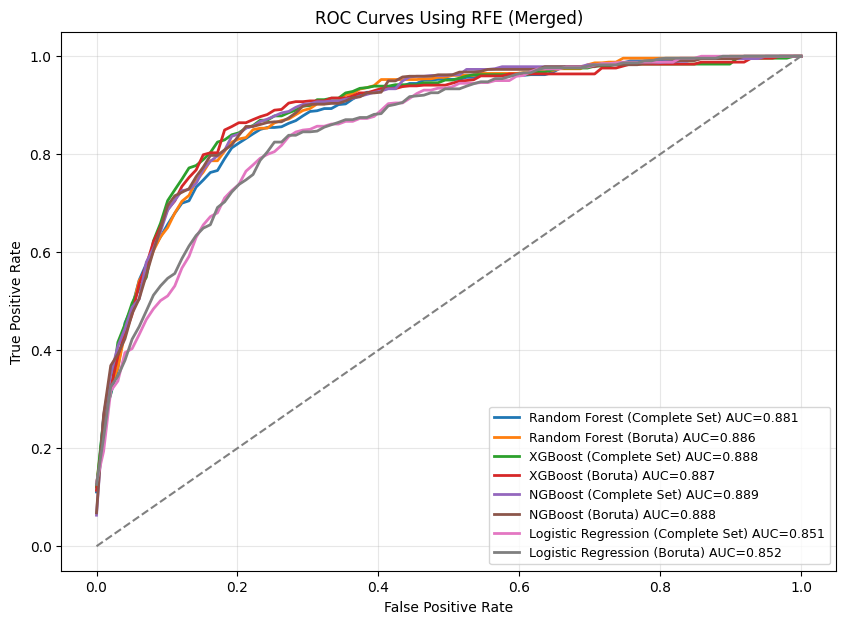

In [28]:
# ROC AUC plotting for ALL models
models_dict = {
    "Random Forest": {"Complete Set": trained_rf_n, "Boruta": trained_rf_t},
    "XGBoost": {"Complete Set": trained_xgb_n, "Boruta": trained_xgb_t},
    "NGBoost": {"Complete Set": trained_ngb_n, "Boruta": trained_ngb_t},
    "Logistic Regression": {"Complete Set": trained_lg_n, "Boruta": trained_lg_t}
}

X_tests_dict = {
    "Complete Set": X_test_knn_t,
    "Boruta": X_test_t
}

plot_roc_multi(models_dict, X_tests_dict, y_test, show_per_class=False)